## Electricity price prediction for NYC

In [1]:
import pandas as pd

import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

Using TensorFlow backend.


In [2]:
df_data = pd.read_csv('full_diff_data_2016_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_data.set_index('time_stamp', inplace = True)

In [3]:
df_data.shape

(17520, 10)

In [4]:
df_data.columns

Index(['time_stamp_local', 'price', 'price_24hr_ago', 'price_diff', 'load',
       'load_24hr_ago', 'load_diff', 'temp', 'temp_24hr_ago', 'temp_diff'],
      dtype='object')

In [5]:
def train_test_ts_split(X, y, percentage=0.9):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    #X_train, Y_train = shuffle_Xy(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

In [6]:
scaler_price = preprocessing.StandardScaler().fit(df_data.price.values.reshape(-1, 1))
scaler_load = preprocessing.StandardScaler().fit(df_data.load.values.reshape(-1, 1))
scaler_temp = preprocessing.StandardScaler().fit(df_data.temp.values.reshape(-1, 1))
# # scaler_price = preprocessing.MinMaxScaler().fit(df_data.price_diff.values.reshape(-1, 1))
# # scaler_load = preprocessing.MinMaxScaler().fit(df_data.load_diff.values.reshape(-1, 1))
# # scaler_temp = preprocessing.MinMaxScaler().fit(df_data.temp_diff.values.reshape(-1, 1))

df_data.loc[:,'price_norm'] = scaler_price.transform(df_data.price.values.reshape(-1, 1))
df_data.loc[:,'load_norm'] = scaler_load.transform(df_data.load.values.reshape(-1, 1))
df_data.loc[:,'temp_norm'] = scaler_temp.transform(df_data.temp.values.reshape(-1, 1))

In [7]:
WINDOW = 24 * 7 - 1
EMB_SIZE = 3
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, df_data.shape[0], STEP): 
    try:
        price_byweek = df_data.price_norm.values[i: i + WINDOW]
        load_byweek = df_data.load_norm.values[i: i + WINDOW]
        temp_byweek = df_data.temp_norm.values[i: i + WINDOW]

#         price_byweek = df_data.price.values[i: i + WINDOW]
#         load_byweek = df_data.load.values[i: i + WINDOW]
#         temp_byweek = df_data.temp.values[i: i + WINDOW]

        
#         price_norm = (np.array(price_byweek) - np.mean(price_byweek)) / np.std(price_byweek)
#         load_norm = (np.array(load_byweek) - np.mean(load_byweek)) / np.std(load_byweek)
#         temp_norm = (np.array(temp_byweek) - np.mean(temp_byweek)) / np.std(temp_byweek)
        
#         x_i = np.column_stack((price_norm, load_norm, temp_norm))
        x_i = np.column_stack((price_byweek, load_byweek, temp_byweek))

        y_i = df_data.price.values[i + WINDOW + FORECAST]
    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)

In [8]:
X.shape, Y.shape

((17352, 167, 3), (17352,))

In [9]:
X_train, X_test, Y_train, Y_test = train_test_ts_split(X, Y, percentage = 0.9)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((15616, 167, 3), (1736, 167, 3), (15616,), (1736,))

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((15616, 167, 3), (1736, 167, 3), (15616,), (1736,))

In [ ]:
checkpointer = ModelCheckpoint(filepath='best_weights.hdf5', 
                               verbose=1, save_best_only=True)

In [11]:
model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=32,
                        filter_length=24,
                        border_mode='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.5))


model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Convolution1D(nb_filter=16,
                        filter_length=2,
                        border_mode='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.7))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer='adam', 
              loss='mse')
history = model.fit(X_train, Y_train, 
          nb_epoch = 50, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.2,
          shuffle=True,
          callbacks=[checkpointer])

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=32, padding="same", kernel_size=24, input_shape=(167, 3))`
  """
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=16, kernel_size=2, padding="same")`
  from ipykernel import kernelapp as app
/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 12492 samples, validate on 3124 samples
Epoch 1/50
12492/12492 [==============================] - 10s 829us/step - loss: 912.2354 - val_loss: 592.2183
Epoch 2/50
12492/12492 [==============================] - 10s 822us/step - loss: 755.7925 - val_loss: 380.0836
Epoch 3/50
12492/12492 [==============================] - 10s 813us/step - loss: 729.6128 - val_loss: 385.1782
Epoch 4/50
12492/12492 [==============================] - 10s 809us/step - loss: 715.1923 - val_loss: 375.6433
Epoch 5/50
12492/12492 [==============================] - 10s 813us/step - loss: 697.3163 - val_loss: 306.4085
Epoch 6/50
12492/12492 [==============================] - 10s 811us/step - loss: 710.1198 - val_loss: 318.4843
Epoch 7/50
12492/12492 [==============================] - 10s 816us/step - loss: 678.7368 - val_loss: 290.8860
Epoch 8/50
12492/12492 [==============================] - 10s 816us/step - loss: 674.1021 - val_loss: 354.5699
Epoch 9/50
12492/12492 [==============================] - 10s 8

In [12]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 167, 32)           2336      
_________________________________________________________________
batch_normalization_1 (Batch (None, 167, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 167, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 83, 16)            1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 83, 16)            64        
_________________________________________________________________
activation_2 (Activation)    (None, 83, 16)            0         
__________

In [13]:
model.save('model.h5')
#model.load_weights("model.hdf5")
pred = model.predict(np.array(X_test))

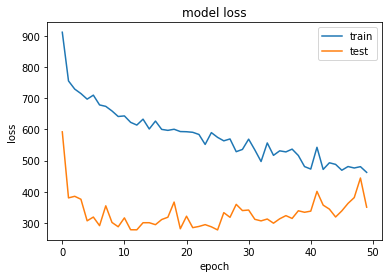

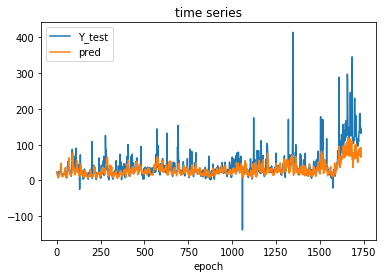

In [14]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
# plt.plot(scaler_price.inverse_transform(Y_test))
# plt.plot(scaler_price.inverse_transform(pred))
plt.plot(Y_test)
plt.plot(pred)


plt.title('time series')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Y_test', 'pred'], loc='best')
# plt.xlim(6000, 6100)
# plt.ylim(0,100)
plt.show()

In [15]:
# np.sqrt(metrics.mean_squared_error(scaler_price.inverse_transform(Y_test), scaler_price.inverse_transform(pred)))
np.sqrt(metrics.mean_squared_error(Y_test.ravel(), pred.ravel()))

26.764288571902362

In [16]:
pred[0]

array([ 22.75250053], dtype=float32)

In [17]:
# metrics.mean_absolute_error(scaler_price.inverse_transform(Y_test), scaler_price.inverse_transform(pred))
np.sqrt(metrics.mean_absolute_error(Y_test.ravel(), pred.ravel()))

3.7151376015423767